In [421]:
import tqdm
import os
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh, eigs
import numpy as np
import numexpr as ne

class TheoreticalPulsedSqueezing2:
    def __init__(self, pump_power, pulse_length, simulation_time, N_points, R_s = 94.5, R_p = 73.4, L = 0.2):
        self.pump_power = pump_power**.5
        self.pulse_length = pulse_length
        self.simulation_time = simulation_time
        self.N_points = N_points
        self.t = np.linspace(0,self.simulation_time,self.N_points)
        self.dt = self.simulation_time/(self.N_points-1)
        self.start_pulse = 3 # ns

        
        # Define parameters cavity
        self.tau_cav = 222e-3 # cavity round trip [ns] 
        self.L = L / 100 # intra cavity loss [%/100]
        self.T1_p = 1-R_p/100 # transmission coefficient @775nm
        self.T1_s = 1-R_s/100 # transmission coefficient @1550nm

        # Calculate important parameters of the cavity
        self.gammaL = (1-np.sqrt(1-self.L))/self.tau_cav
        self.gamma_p_M1 = (1-np.sqrt(1-self.T1_p))/self.tau_cav
        self.gamma_p = self.gamma_p_M1 + self.gammaL
        self.gamma_s_M1 = (1-np.sqrt(1-self.T1_s))/self.tau_cav
        self.gamma_s = self.gamma_s_M1 + self.gammaL
        self.betamax = np.sqrt(2*self.gamma_p_M1)/self.gamma_p

        self.square_pulse_fun()
        self.intra_cavity_fun()
        self.integrate_beta_fun()
        self.create_matrix_NM_fast()


    def square_pulse_fun(self):
        start_idx = int(np.searchsorted(self.t, self.start_pulse))
        end_idx = int(np.searchsorted(self.t, self.start_pulse + self.pulse_length))

        self.square_pulse = np.zeros_like(self.t, dtype=np.float64)
        self.square_pulse[start_idx:end_idx+1] = 1.0  
    def intra_cavity_fun(self):
        # Precompute constants
        A = np.sqrt(2 * self.gamma_p_M1) / self.gamma_p

        # Initialize array
        beta = np.zeros_like(self.t, dtype=np.float64)

        # Find indices of pulse start and end
        start_idx = np.searchsorted(self.t, self.start_pulse)
        end_idx = np.searchsorted(self.t, self.start_pulse + self.pulse_length)

        # During the pulse
        beta[start_idx:end_idx+1] = A * (1 - np.exp(-self.gamma_p * (self.t[start_idx:end_idx+1] - self.start_pulse)))

        # After the pulse
        beta[end_idx+1:] = A * (np.exp(self.gamma_p * self.pulse_length) - 1) * np.exp(-self.gamma_p * self.t[end_idx+1:])

        self.beta = beta
    def integrate_beta_fun(self):
        a = self.start_pulse
        b = self.start_pulse + self.pulse_length
        gamma_p = self.gamma_p
        first = np.sqrt(2 * self.gamma_p_M1) / gamma_p

        N = self.N_points
        dt = self.dt

        # Time points
        time_points = np.arange(N, dtype=np.float64) * dt

        # Precompute exponentials using NumExpr
        exp_t         = ne.evaluate("exp(-gamma_p * time_points)")
        exp_t_minus_a = ne.evaluate("exp(-gamma_p * (time_points - a))")
        exp_t_minus_b = ne.evaluate("exp(-gamma_p * (time_points - b))")
        exp_a         = ne.evaluate("exp(gamma_p * a)")
        exp_b         = ne.evaluate("exp(gamma_p * b)")

        # Initialize output
        matrix_beta = np.zeros((N, N), dtype=np.float64)

        # Upper triangle indices
        i, j = np.triu_indices(N)
        t1 = time_points[i]
        t2 = time_points[j]

        # Precompute exponentials at selected indices
        exp_t1 = exp_t[i]
        exp_t2 = exp_t[j]
        exp_t1_a = exp_t_minus_a[i]
        exp_t2_a = exp_t_minus_a[j]
        exp_t2_b = exp_t_minus_b[j]

        # Conditions
        cond1 = (t1 <= a) & (a <= t2) & (t2 < b)
        cond2 = (a <= t1) & (t1 <= b) & (a <= t2) & (t2 <= b)
        cond3 = (t1 <= a) & (t2 >= b)
        cond4 = (a <= t1) & (t1 < b) & (t2 >= b)
        cond5 = (t1 >= b) & (t2 >= b)

        # Compute beta using NumExpr
        beta_values = ne.evaluate(
            "(cond1 * ((exp_t2_a - 1)/gamma_p + t2 - a) + "
            "cond2 * ((exp_t2_a - exp_t1_a)/gamma_p + t2 - t1) + "
            "cond3 * ((exp_t2 * (exp_a - exp_b))/gamma_p + b - a) + "
            "cond4 * ((1 + exp_t2_a - exp_t1_a - exp_t2_b)/gamma_p + b - t1) + "
            "cond5 * ((exp_t2 - exp_t1) * (exp_a - exp_b)/gamma_p)) * first",
            local_dict={
                't1': t1, 't2': t2, 'a': a, 'b': b, 'gamma_p': gamma_p,
                'first': first, 'exp_a': exp_a, 'exp_b': exp_b,
                'exp_t1': exp_t1, 'exp_t2': exp_t2, 'exp_t1_a': exp_t1_a,
                'exp_t2_a': exp_t2_a, 'exp_t2_b': exp_t2_b,
                'cond1': cond1, 'cond2': cond2, 'cond3': cond3, 'cond4': cond4, 'cond5': cond5
            }
        )

        # Fill matrix
        matrix_beta[i, j] = beta_values
        matrix_beta[j, i] = beta_values

        self.matrix_beta = matrix_beta
    def calculate_all_G(self):
        # Time points (1D)
        time_points = np.arange(self.N_points) * self.dt
        gamma_s = self.gamma_s

        # Get lower triangle indices (including diagonal)
        i_idx, j_idx = np.tril_indices(self.N_points)

        # Convert to physical times
        t1c = time_points[i_idx]
        t2c = time_points[j_idx]

        # Integer indices for beta lookup
        beta_vals = self.matrix_beta[i_idx, j_idx]
        arg = self.pump_power * self.gamma_s / self.betamax * beta_vals

        # Evaluate in numexpr
        exp_term = ne.evaluate("exp(-gamma_s * (t1c - t2c))")  # t1 >= t2
        cosh_vals = ne.evaluate("cosh(arg)")
        sinh_vals = ne.evaluate("sinh(arg)")

        # Allocate output
        G11_ = np.zeros((self.N_points, self.N_points), dtype=np.float64)
        G12_ = np.zeros_like(G11_)

        # Fill only lower triangle
        G11_[i_idx, j_idx] = ne.evaluate("exp_term * cosh_vals")
        G12_[i_idx, j_idx] = ne.evaluate("exp_term * sinh_vals")

        return G11_, G12_ 
    def create_matrix_NM_fast(self):
        G11_, G12_ = self.calculate_all_G()
        
        # Precompute constants
        scale_outer = 2 * self.gamma_s_M1
        scale_matmul = 2 * self.gamma_s * self.dt

        # Outer product term (elementwise multiply via numexpr)
        outer_term = ne.evaluate(
            "g12_col0_col * g12_col0_row",
            local_dict={
                'g12_col0_col': G12_[:, 0][:, None],
                'g12_col0_row': G12_[:, 0][None, :]
            }
        )


        # Matrix multiply term (BLAS-optimized)
        matmul_term = np.einsum("ik,jk->ij", G12_, G12_, optimize=True)
        # Combine using numexpr to avoid large intermediate arrays
        self.N = ne.evaluate("scale_outer * (outer_term + scale_matmul * matmul_term)")

        

        
        
        outer_term = ne.evaluate(
            "g11_col0_col * g12_col0_row",
            local_dict={
                'g11_col0_col': G11_[:, 0][:, None],
                'g12_col0_row': G12_[:, 0][None, :]
            }
        )

        matmul_term = np.einsum("ik,jk->ij", G11_, G12_, optimize=True)

        self.M = ne.evaluate(
            "scale_outer * (outer_term + scale_matmul * matmul_term - G12_T)",
            local_dict={
                'scale_outer': scale_outer,
                'outer_term': outer_term,
                'scale_matmul': scale_matmul,
                'matmul_term': matmul_term,
                'G12_T': G12_.T
            }
        )
                                    

        self.eigenvalues, self.eigenvectors = eigsh(self.N, k=10, which='LM')
        self.eigenvalues, self.eigenvectors = self.eigenvalues, self.eigenvectors


        self.first_term = 2 * np.einsum('ij,ik,kj->j', self.eigenvectors, self.N, self.eigenvectors)
        self.second_term = 2 * np.einsum('ij,ik,kj->j', self.eigenvectors, self.M, self.eigenvectors)


        self.first_eigenvector = self.eigenvectors[:,-1]
        self.squeezing_modes = 10*np.log10((self.first_term - self.second_term)*self.dt + 1)
        self.antisqueezing_modes = 10*np.log10((self.first_term + self.second_term)*self.dt + 1)
        
        self.squeezing = self.squeezing_modes[-1]
        self.antisqueezing = self.antisqueezing_modes[-1]

        self.purity = self.eigenvalues[-1] / np.sum(self.eigenvalues)
        self.schmidt = np.sum(self.eigenvalues)**2 / np.sum(self.eigenvalues**2)


class plot_pulsed:
    def __init__(self, pulsed:TheoreticalPulsedSqueezing2):
        self.pulsed = pulsed
    def plot_eigenmodes(self, N):
        modes = self.pulsed.eigenvectors.copy()

        # Auto sign flipping so first significant lobe (> 0.2) is positive
        for i in range(N):
            idx = np.argmax(np.abs(modes[:, -i-1]) > 0.2 * self.pulsed.dt)
            if modes[idx, -i-1] < 0:
                modes[:, -i-1] *= -1

        # Plot
        for i in range(N):
            plt.plot(self.pulsed.t, modes[:, -i-1] / self.pulsed.dt ** 0.5,
                    label=f"{i} - Schmidt mode")

        plt.xlim([0, 50])
        plt.xlabel("Time [ns]")
        plt.ylabel("Eigenmode amplitude")
        plt.grid()
        plt.legend()
        plt.show()



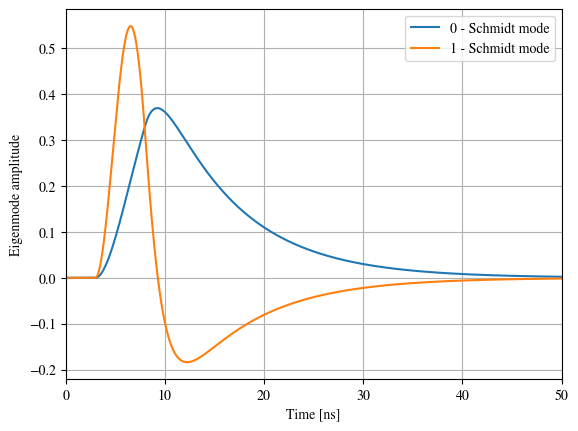

In [422]:
b = TheoreticalPulsedSqueezing2(pump_power=0.2, pulse_length=5, simulation_time=50,N_points=2000, R_s=94.5, R_p=73.4, L=0.2)
c = plot_pulsed(b)
c.plot_eigenmodes(2)

100%|██████████| 101/101 [02:38<00:00,  1.57s/it]


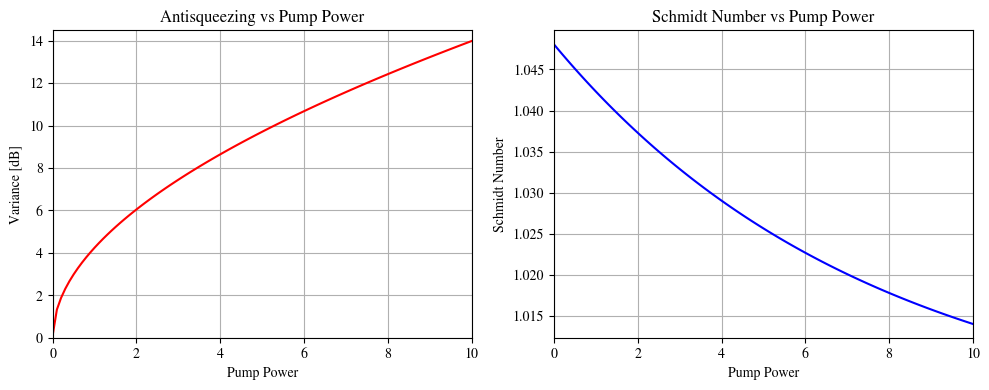

In [445]:
import numpy as np
import matplotlib.pyplot as plt

pump_powers = np.linspace(0.001, 10, 101)
antisq_vals = []
schmidt_vals = []

# Run simulations and collect results
for pump_power in tqdm.tqdm(pump_powers):
    b = TheoreticalPulsedSqueezing2(
        pump_power=pump_power,
        pulse_length=5,
        simulation_time=50,
        N_points=2000,
        R_s=94.5,
        R_p=73.4,
        L=0.2
    )
    antisq_vals.append(b.antisqueezing)
    schmidt_vals.append(b.schmidt)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Antisqueezing subplot
axs[0].plot(pump_powers, antisq_vals, 'r')
axs[0].set_title("Antisqueezing vs Pump Power")
axs[0].set_xlabel("Pump Power")
axs[0].set_ylabel("Variance [dB]")
axs[0].set_ylim((0, np.max(antisq_vals)+.5))
axs[0].grid(True)
axs[0].set_xlim((0, np.max(pump_powers)))

# Schmidt subplot
axs[1].plot(pump_powers, schmidt_vals, 'b')
axs[1].set_title("Schmidt Number vs Pump Power")
axs[1].set_xlabel("Pump Power")
axs[1].set_ylabel("Schmidt Number")
axs[1].grid(True)
axs[1].set_xlim((0, np.max(pump_powers)))

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

pulse_lengths = np.linspace(0.1, 10, 100)  # Pulse lengths from 1 to 10
antisq_vals = []
schmidt_vals = []

# Run simulations and collect results
for pulse_length in tqdm.tqdm(pulse_lengths):
    b = TheoreticalPulsedSqueezing2(
        pump_power=1,               # Fixed pump power
        pulse_length=pulse_length,  # Variable pulse length
        simulation_time=50,
        N_points=4000,
        R_s=94.5,
        R_p=73.4,
        L=0.2
    )
    antisq_vals.append(b.antisqueezing)
    schmidt_vals.append(b.schmidt)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Antisqueezing subplot
axs[0].plot(pulse_lengths, antisq_vals, 'r')
axs[0].set_title("Antisqueezing vs Pulse Length at peak = threshold")
axs[0].set_xlabel("Pulse Length")
axs[0].set_ylabel("Variance [dB]")
axs[0].set_ylim((0, np.max(antisq_vals)+0.5))
axs[0].grid(True)
axs[0].set_xlim((0, np.max(pulse_lengths)))

# Schmidt subplot
axs[1].plot(pulse_lengths, schmidt_vals, 'b')
axs[1].set_title("Schmidt Number vs Pulse Length at peak = threshold")
axs[1].set_xlabel("Pulse Length")
axs[1].set_ylabel("Schmidt Number")
axs[1].grid(True)
axs[1].set_xlim((0, np.max(pulse_lengths)))

plt.tight_layout()
plt.show()


 33%|███▎      | 33/100 [01:53<04:59,  4.48s/it]